# **Asset Management Project**

### 53127 - Miguel Teodoro

## **Data**

In [1]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, floor
import numpy as np

In [2]:
# get assigned tickers
tickers_df = pd.read_excel("Tickers_T4.xlsx")
tickers = list(tickers_df["Tickers 23"])

# Define the date range for the data
start_date = '01/01/1980'
end_date = '12/31/2022'

In [3]:
# get permnos corresponding to given tickers (avoid problems with changing ticker name)
tickers_permno = pd.read_csv('tickers_permno.csv')
permnos = list(tickers_permno['permno'])

In [4]:
# price data
crsp_data_permno = pd.read_csv('crsp_data_permno.csv')

# book-to-market data
bm_permnos_df = pd.read_csv("bm-ratios-permnos.csv")
bm_permnos_df = bm_permnos_df[['public_date', 'bm', 'cusip', 'permno', 'TICKER']]

# observe we only have data for 48 out of the 50 assigned tickers
print(len(bm_permnos_df[bm_permnos_df['permno'].isin(permnos)]['permno'].unique()))

48


In [5]:
# match historical tickers with current ticker according to permno
permno_tick_dict = dict(zip(tickers_permno['permno'].astype(int), tickers_permno['ticker']))
bm_permnos_df['TICKER'] = bm_permnos_df['permno'].map(permno_tick_dict)

In [6]:
# pass permno variable to int
crsp_data_permno['permno'] = crsp_data_permno['permno'].astype(int)

# change dates format so they can match (new format ex.: 2010-03)
bm_permnos_df['public_date'] = pd.to_datetime(bm_permnos_df['public_date']).dt.strftime('%Y-%m')
crsp_data_permno['date'] = pd.to_datetime(crsp_data_permno['date']).dt.strftime('%Y-%m')

In [7]:
# merge the two tables based on permno and date
merged_df = pd.merge(bm_permnos_df, crsp_data_permno, left_on=['permno', 'public_date'], right_on=['permno', 'date'], how='left')

# drop the redundant 'date' column
merged_df.drop(columns=['date'], inplace=True)
merged_df = merged_df.rename(columns={'public_date': 'date', 'TICKER': 'ticker'})

In [8]:
# observe attained df
merged_df

,date,bm,cusip,permno,ticker,prc
0,1987-08,0.392,27874010,11403,CDNS,8.625000
1,1987-09,0.392,27874010,11403,CDNS,9.250000
2,1987-10,0.392,27874010,11403,CDNS,6.375000
3,1987-11,0.292,27874010,11403,CDNS,4.500000
4,1987-12,0.292,27874010,11403,CDNS,6.000000
...,...,...,...,...,...,...
17474,2022-08,0.014,34959E10,93132,FTNT,48.689999
17475,2022-09,0.014,34959E10,93132,FTNT,49.130001
17476,2022-10,0.014,34959E10,93132,FTNT,57.160000
17477,2022-11,0.014,34959E10,93132,FTNT,53.160000


In [9]:
# create a prices only df
prices = merged_df.groupby(['date', 'ticker'])['prc'].first().unstack()

In [10]:
# calculate returns based on prices
returns = prices.pct_change(fill_method=None)

As instructed by the professor we will remove outliers in the returns dataframe, so as to not bias the data. We decided to drop variations in price above 65%, since we believe that this kind of change in valuation of a stock is likely to only happen when there are corporate events, like stock splits.

In [11]:
# filter out values above 0.65 and below -0.65 (considered to be outliers)

returns = returns.mask((returns < -0.65) | (returns > 0.65)).fillna(value=np.nan)

Below there are two functions to observe price distribution.

In [12]:
def plot_histogram(data, mf, lines):
    """
    function that plots a histogram for each numerical feature
    input lines: is to determine the number of lines to configure the plot
    """
    # preparing the figure by creating individual axes where each histogram will be placed
    fig, axes = plt.subplots(lines, ceil(len(mf) / lines), figsize = (30, 20), constrained_layout = True)

    # ploting the data
    # iterating across axes objects and associate each histogram:
    for ax, feat in zip(axes.flatten(), mf):
        ax.hist(data[feat], bins = 20, color = '#8d99ae')
        ax.set_xlabel(feat, fontsize = 10)

    fig.suptitle('Histograms with 20 bins for all numeric variables', fontsize = 12)

    # showing the plot
    plt.show()

In [13]:
def plot_dist_var(data, var, bins=20):
    """
    function that plots a histogram for specific numerical feature
    """

    plt.hist(data[var], bins = bins, color = '#8d99ae')
    plt.title(f'Histogram with {bins} bins for variable: {var}', fontsize = 12)

    # showing the plot
    plt.show()

In [14]:
# plot_histogram(returns, returns.columns, 8)

# 1.
#### For this exercise use the file ”Tickers”, which specifies the tickers of the 50 stocks you should use given your number. Retrieve monthly Book-to-Market data and monthly prices for your stocks from 1980. Present annualized performance statistics (average return, volatility, Sharpe ratio, skewness, kurtosis and max drawdown) for your stocks.

**Define Functions for performance statistics**

Note that in this case we will assume rf=0.

In [15]:
import pandas as pd
import numpy as np
import scipy.stats

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})


def summary_stats(r, riskfree_rate=0):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(lambda r: scipy.stats.skew(r, nan_policy='omit'))
    kurt = r.aggregate(lambda r: scipy.stats.kurtosis(r, nan_policy='omit'))
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew.astype(float),
        "Kurtosis": kurt,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

## Statistical Summary

In [16]:
summary = summary_stats(returns, riskfree_rate=0)
summary.round(decimals=3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown
ticker,,,,,,
A,0.019,0.398,0.395,3.534,0.048,-0.874
AAL,-0.087,0.486,-0.059,2.441,-0.178,-0.999
AEE,0.049,0.179,-0.341,2.347,0.272,-0.586
AIZ,0.039,0.265,-1.374,12.798,0.146,-0.700
ALB,0.062,0.359,0.000,2.895,0.173,-0.764
AVY,0.053,0.298,-1.302,7.194,0.177,-0.723
BAX,0.005,0.286,-1.707,9.623,0.016,-0.803
BEN,0.024,0.389,-0.541,4.565,0.062,-0.892
BLK,0.090,0.304,0.212,1.806,0.297,-0.570


We can notice that D and AIZ have a very high kurtosis and a quite negative skewness justified by the extreme value seen below. These values could also be considered outliers. In this case we opted by not removing them, since there is a also a possibility that they are real, and that we could be losing relevant information.

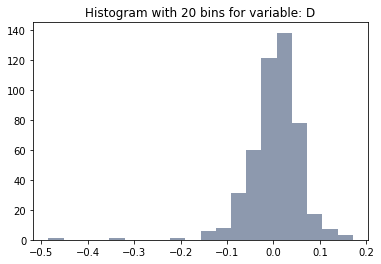

In [17]:
plot_dist_var(returns, 'D')

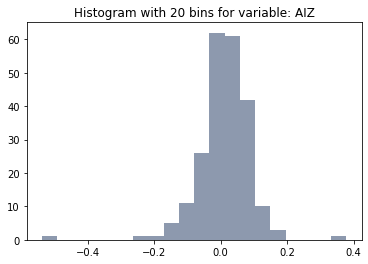

In [18]:
plot_dist_var(returns, 'AIZ')

# 2.
#### For each stock and each date, build a Momentum indicator which is defined as the cumulated return over the past six months (note that, by construction, during the first six months of the sample it will not be possible to build such momentum indicator). Use the characteristics Book-to-Market and Momentum to build tercile portfolios, called: V alue high, V alue med and V alue low for Value (book-to-market); and M oM high, M oM med and M oM low for Momen- tum. To construct the six portfolios, at each date and for each one of the two characteristic, split your 50 stocks in three equally weighted groups of similar sizes (example: for momentum in Jan 2000 you may have 16 stocks in the low Momentum group, 15 in the Middle group, 15 in the high Momentum group and 4 stocks with missing observations at this date). Present annualized performance statistics for the 6 portfolios.

In [19]:
# get momentum portfolios based on cumulative past returns (6-month periods)
def momentum(returns, lookback_period):

    # get number of rows
    n_periods = returns.shape[0]

    # create rolling windows list
    windows = [(start, start+lookback_period)
               for start in range(n_periods-lookback_period+1)]
    
    # count na cols per window
    nas = [(returns.iloc[win[0]:win[1]].isna().sum() > 0).sum()
            for win in windows]
    
    # only keep windows with enough data (30+ observations)
    nas_to_30 = returns.shape[1] - 29
    actual_windows = [windows[i] for i in range(len(windows)) if nas[i] < nas_to_30]

    # gets ranks based on cumulative returns for each window (1 - highest return; 30 - lowest return)
    ranks = [((1 + returns.iloc[win[0]:win[1]]).cumprod() - 1).iloc[-1].rank(ascending=False)
            for win in actual_windows]
    
    # get terciles
    terciles = [
                [
                 list(rank[rank <= floor(rank.count()/3)].index),     # 1st tercile
                 
                 list(rank[(rank > floor(rank.count()/3)) & (rank <= floor(rank.count()/3) * 2)].index),    # 2nd tercile

                 list(rank[rank > floor(rank.count()/3) * 2].index)       # 3rd tercile
                 ]
                for rank in ranks]

    # associate dates to portfolios
    dates = [returns.reset_index().iloc[win[1]-1,0]
             for win in actual_windows]
    
    associate = [[dates[date], terciles[date][0], terciles[date][1], terciles[date][2]] 
                 for date in range(len(dates))]
    
    # finally transform to df
    df = pd.DataFrame(associate, columns=['Date', 'MoM_high', 'MoM_med', 'MoM_low'])

    # shift portfolio constitution by 1 month -> predicting based on past returns, to avoid forward-looking bias
    df[['MoM_high', 'MoM_med', 'MoM_low']] = df[['MoM_high', 'MoM_med', 'MoM_low']].shift(periods=1, axis='rows')

    return df

In [20]:
# create book-to-market df
bm_ratios = merged_df.groupby(['date', 'ticker'])['bm'].first().unstack()

In [21]:
# get value portfolios based on past month book-to-market
def value(bm):

    # get number of rows
    n_periods = bm.shape[0]

    # create rows list
    rows = [row
               for row in range(n_periods)]
    
    # count na cols per row
    nas = [bm.iloc[row].isna().sum()
            for row in rows]
    
    # only keep rows with enough data (30+ observations)
    nas_to_30 = bm.shape[1] - 29
    actual_rows = [rows[i] for i in range(len(rows)) if nas[i] < nas_to_30]

    # gets ranks based on book-to-market for each row (1 - highest return; 30 - lowest return)
    ranks = [bm.iloc[row].rank(ascending=False)
            for row in actual_rows]
    
    # get terciles
    terciles = [
                [
                 list(rank[rank <= floor(rank.count()/3)].index),     # 1st tercile
                 
                 list(rank[(rank > floor(rank.count()/3)) & (rank <= floor(rank.count()/3) * 2)].index),    # 2nd tercile

                 list(rank[rank > floor(rank.count()/3) * 2].index)       # 3rd tercileb
                 ]
                for rank in ranks]
    
    # associate dates to portfolios
    dates = [bm.reset_index().iloc[row,0]
             for row in actual_rows]
    associate = [[dates[date], terciles[date][0], terciles[date][1], terciles[date][2]] 
                 for date in range(len(dates))]
    
    # finally transform to df
    df = pd.DataFrame(associate, columns=['Date', 'Value_high', 'Value_med', 'Value_low'])

    # shift portfolio constitution by 1 month -> predicting based on past returns, to avoid forward-looking bias
    df[['Value_high', 'Value_med', 'Value_low']] = df[['Value_high', 'Value_med', 'Value_low']].shift(periods=1, axis='rows')

    return df

In [22]:
# store momentum portfolios
mom_portf = momentum(returns, 6)

In [23]:
# store value portfolios
val_portf = value(bm_ratios)

##### **Performance.**

In [24]:
# get returns for each portfolio as average return of stocks in each portfolio (equal-weighted)
mom_rets = pd.DataFrame({  'Date': [date
                                    for date in mom_portf.Date[1:]],  
                            'MoM_high': [returns[mom_portf.set_index('Date').loc[date]['MoM_high']].loc[date].mean()
                                         for date in mom_portf.Date[1:]],
                            'MoM_med': [returns[mom_portf.set_index('Date').loc[date]['MoM_med']].loc[date].mean()
                                        for date in mom_portf.Date[1:]],
                            'MoM_low': [returns[mom_portf.set_index('Date').loc[date]['MoM_low']].loc[date].mean()
                                        for date in mom_portf.Date[1:]]}).set_index('Date')

In [25]:
summary_stats(mom_rets, riskfree_rate=0).round(decimals=3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown
MoM_high,0.039,0.194,-0.318,0.118,0.199,-0.644
MoM_med,0.092,0.168,-0.561,1.392,0.549,-0.538
MoM_low,0.120,0.224,-0.042,1.373,0.536,-0.609


In this case, we do not find evidence of momentum in our analysis. There could be multiple reasons as to why this is happening:

- Data is unrepresentative of general market conditions (these particular 48 stocks, may not present strong momentum)
- Momentum is misconstructed. Momentum as described in the initial paper by Jegadeesh and Titman (1993) is stronger in further away periods. In their initial construction they analyse stock holding periods of 1, 2, 3 and 4 quarters, instead of only one-month (and found that evidence for momentum is stronger, the larger the holding period is). Also, it is common in equity Momentum portfolio construction to leave a 1-month gap, to account for short-term mean reversion and liquidity constraints (which in this case, is the month we are investing in).
- Terciles are unrepresentative. Usually long-shorts are built on decile divisions.

In [26]:
# get returns for each portfolio as average return of stocks in each portfolio (equal-weighted)
val_rets = pd.DataFrame({  'Date': [date
                                    for date in val_portf.Date[1:]],
                            'Value_high': [returns[val_portf.set_index('Date').loc[date]['Value_high']].loc[date].mean()
                                         for date in val_portf.Date[1:]],
                            'Value_med': [returns[val_portf.set_index('Date').loc[date]['Value_med']].loc[date].mean()
                                        for date in val_portf.Date[1:]],
                            'Value_low': [returns[val_portf.set_index('Date').loc[date]['Value_low']].loc[date].mean()
                                        for date in val_portf.Date[1:]]}).set_index('Date')

In [27]:
summary_stats(val_rets, riskfree_rate=0).round(decimals=3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown
Value_high,0.070,0.179,-0.279,1.726,0.393,-0.574
Value_med,0.115,0.202,-0.321,1.411,0.568,-0.546
Value_low,0.066,0.199,-0.245,0.171,0.332,-0.608


There also seems to be little evidence for Value stocks, although in this case, the high value portfolio outperforms the low value one. Also strange to notice that the "med" portfolio, presents the better performance of the 3.

# 3.
#### Build two long-short portfolios for Value and Momentum using the tercile portfolios. Backtest the portfolio and an equal weighed portfolio investing in the 50 stocks. Plot cumulated returns and present annualized performance statistics.

In [28]:
# building long-shorts simply basing on returns of high (weight of 1) minus returns of low (weight of -1)

value_long_short = val_rets['Value_high'] - val_rets['Value_low']
value_long_short.name = 'Value_LS'

momentum_long_short = mom_rets['MoM_high'] - mom_rets['MoM_low']
momentum_long_short.name = 'Momentum_LS'

# build equal-weight as mean return for available stocks
equal_weight = returns.mean(axis=1)
equal_weight.index.names = ['Date']
equal_weight.name = 'EW_portf'

In [29]:
# function to outer merge multiple dfs
def merge_mult_dfs_outer(series, left_index, right_index):
    merged_df = series[0]
    for s in series[1:]:
        merged_df = pd.merge(merged_df, s, left_index=left_index, right_index=right_index, how='outer')
    return merged_df

In [30]:
series = [value_long_short, momentum_long_short, equal_weight]
df3_1 = merge_mult_dfs_outer(series, left_index=True, right_index=True)

In [31]:
summary_stats(df3_1, riskfree_rate=0).round(decimals=3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown
Value_LS,-0.009,0.177,0.821,2.843,-0.051,-0.660
Momentum_LS,-0.060,0.187,-0.692,1.596,-0.320,-0.954
EW_portf,0.107,0.169,-0.418,1.404,0.633,-0.547


As it was expected according to the performance analysis seen in Q2. the value portfolio shows a near zero difference between the long portfolio and the short portfolio. Also, the momentum portfolio has negative performance, since the bottom tercile outperforms the top. The equal-weighted portfolio has a better performance than both, presenting values that would be expected by holding the market portfolio.

In [32]:
# function to inner merge multiple dfs
def merge_mult_dfs_inner(series, on):
    merged_df = series[0]
    for s in series[1:]:
        merged_df = pd.merge(merged_df, s, on=on, how='inner')
    return merged_df

In [33]:
df3_2 = merge_mult_dfs_inner(series, on='Date')

In [34]:
import seaborn as sns

def plot_cumulative_returns(df, palette, labels):
    """
    Plots the cumulative returns of return columns in a pandas dataframe.
    """

    plt.rcParams["figure.figsize"] = (20,16)
    dates = df['Date']
    xticks = df['Date'][list(np.arange(4,len(dates),6))]
    colors = sns.color_palette(palette, len(df.columns)-1)

    for i, column in enumerate(df.drop('Date', axis=1).columns):
        cum_ret = (1 + df[column]).cumprod() - 1
        plt.plot(dates, cum_ret, label=labels[i], color=colors[i])

    # Add a legend and title to the plot
    plt.xticks(xticks, rotation=60)
    plt.legend(prop={'size': 15})
    plt.title("Cumulative Returns")

    # Show the plot
    plt.show()

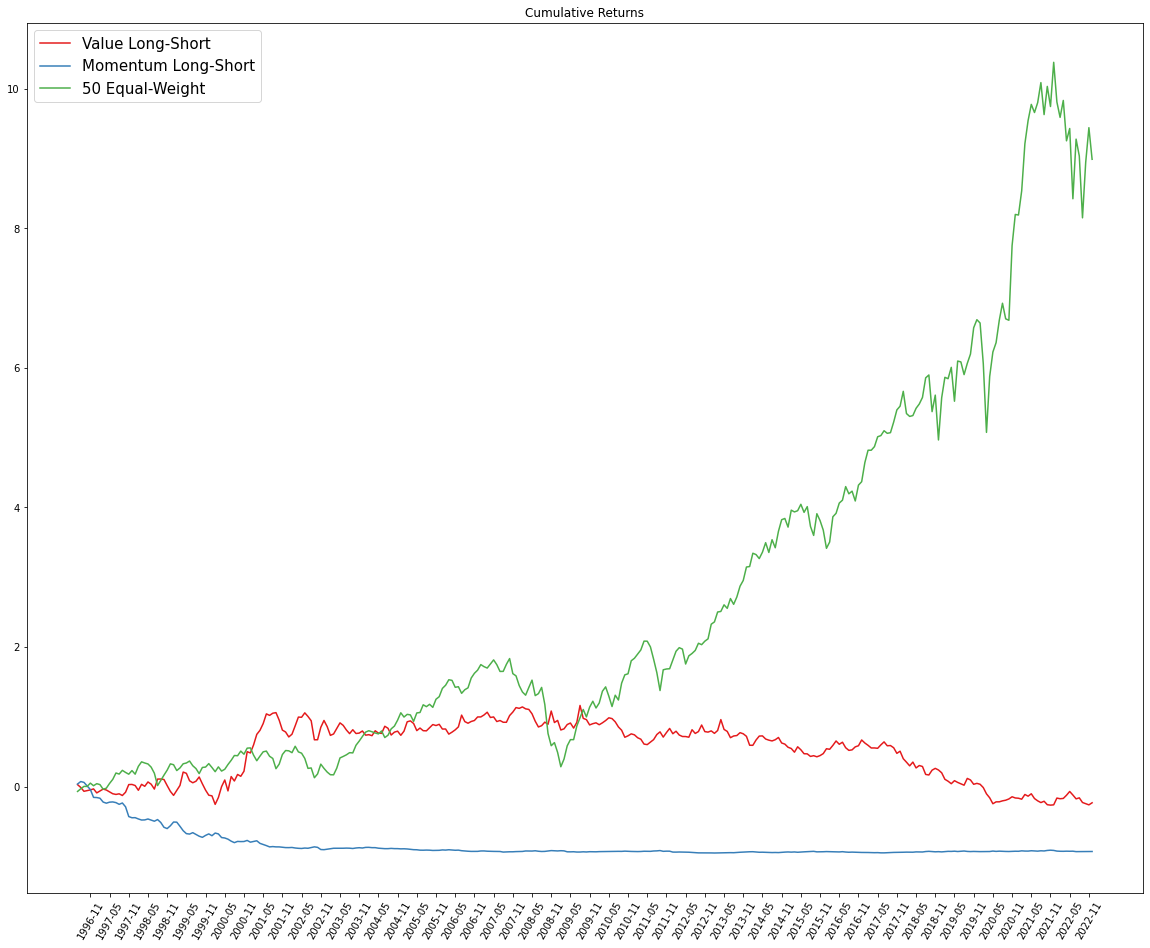

In [35]:
plot_cumulative_returns(df3_2.reset_index(), 'Set1', labels=['Value Long-Short', 'Momentum Long-Short', '50 Equal-Weight'])

Momentum loses all value between '96 and '02. Value portfolio has it's largest value gain until the early 2000's but has been slowly deteriorating since. For every $1 invested in the equal-weighted portfolio in 1996, an investor would have by now, $10. Keep in mind that the difference between the equal-weighted and the long-shorts is normal, since long-shorts are offsetting each other, and not going with the market, which has an upwards tendency.

# 4.
#### Naturally, neither Value nor Momentum is the perfect predictor of returns. To combine the information that each characteristic contains, construct a composite characteristics. To this end, standardize in each month each characteristic to have a cross-sectional mean (standard deviation) of zero (one) and combine them into a single characteristic Sit defined as: $$ S_{it} = \frac{BM_{it} – E_t[BM_{it}]}{σ_t(BM_{it})} + \frac{Mom_{it} – E_t[Mom_{it}]}{σ_t(Mom_{it})} $$ where the Mean and Standard deviation are taken over all stocks in the cross-section of month t. Now, sort the stocks on the composite characteristic and construct the long-short portfolio using tercile portfolios on this charateristics. Backtest this long-short portfolio. Plot cumulated returns and present annualized performance statistics for this long-short portfolio.



In [36]:
# function to calculate the Sit formula for two series

def dist_adjust(s1, s2):

    mean1 = s1.mean()
    std1 = s1.std()
    mean2 = s2.mean()
    std2 = s2.std()

    # standardize the series
    s1_standardized = (s1 - mean1) / std1
    s2_standardized = (s2 - mean2) / std2

    final_s = s1_standardized + s2_standardized

    return final_s

In [37]:
# get combined information indicator portfolios

def sit(returns, lookback_period, bm):

    # get number of rows
    n_periods = returns.shape[0]

    # create rolling windows list
    windows = [(start, start+lookback_period)
               for start in range(n_periods-lookback_period+1)]
    
    # count na cols per window
    nas_rets = [(returns.iloc[win[0]:win[1]].isna().sum() > 0).sum()
                for win in windows]
    
    nas_bms = [bm.iloc[win[1]-1].isna().sum()
                for win in windows]
    
    # only keep windows with enough data (30+ observations) for both our factors
    nas_to_30rets = returns.shape[1] - 29
    nas_to_30bms = bm.shape[1] - 29

    actual_windows = [windows[i] for i in range(len(windows)) if ((nas_rets[i] < nas_to_30rets) & (nas_bms[i] < nas_to_30bms))]


    # gets ranks based on Sit for each window (1 - highest return; 30 - lowest return)
    ranks = [dist_adjust(((1 + returns.iloc[win[0]:win[1]]).cumprod() - 1).iloc[-1], bm.iloc[win[1]-1]).rank(ascending=False)
                    for win in actual_windows]
    
    # get terciles
    terciles = [
                [
                 list(rank[rank <= floor(rank.count()/3)].index),     # 1st tercile
                 
                 list(rank[(rank > floor(rank.count()/3)) & (rank <= floor(rank.count()/3) * 2)].index),    # 2nd tercile

                 list(rank[rank > floor(rank.count()/3) * 2].index)       # 3rd tercile
                 ]
                for rank in ranks]

    # associate dates to portfolios
    dates = [returns.reset_index().iloc[win[1]-1,0]
             for win in actual_windows]
    
    associate = [[dates[date], terciles[date][0], terciles[date][1], terciles[date][2]] 
                 for date in range(len(dates))]
    
    # finally transform to df
    df = pd.DataFrame(associate, columns=['Date', 'Sit_high', 'Sit_med', 'Sit_low'])

    # shift portfolio constitution by 1 month -> predicting based on past returns, to avoid forward-looking bias
    df[['Sit_high', 'Sit_med', 'Sit_low']] = df[['Sit_high', 'Sit_med', 'Sit_low']].shift(periods=1, axis='rows')

    return df

In [38]:
# store portfolios based on Sit
sit_portf = sit(returns, 6, bm_ratios)

In [39]:
# get returns for each of the portfolios in each date
sit_rets = pd.DataFrame({  'Date': [date
                                    for date in sit_portf.Date[1:]],  
                            'Sit_high': [returns[sit_portf.set_index('Date').loc[date]['Sit_high']].loc[date].mean()
                                         for date in sit_portf.Date[1:]],
                            'Sit_med': [returns[sit_portf.set_index('Date').loc[date]['Sit_med']].loc[date].mean()
                                        for date in sit_portf.Date[1:]],
                            'Sit_low': [returns[sit_portf.set_index('Date').loc[date]['Sit_low']].loc[date].mean()
                                        for date in sit_portf.Date[1:]]}).set_index('Date')

In [40]:
summary_stats(sit_rets, riskfree_rate=0).round(decimals=3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown
Sit_high,0.054,0.178,-0.363,0.765,0.302,-0.515
Sit_med,0.061,0.181,-0.531,0.839,0.336,-0.561
Sit_low,0.130,0.210,-0.136,1.279,0.619,-0.587


In [41]:
# build the long-short
sit_long_short = sit_rets['Sit_high'] - sit_rets['Sit_low']
sit_long_short.name = 'Sit_LS'

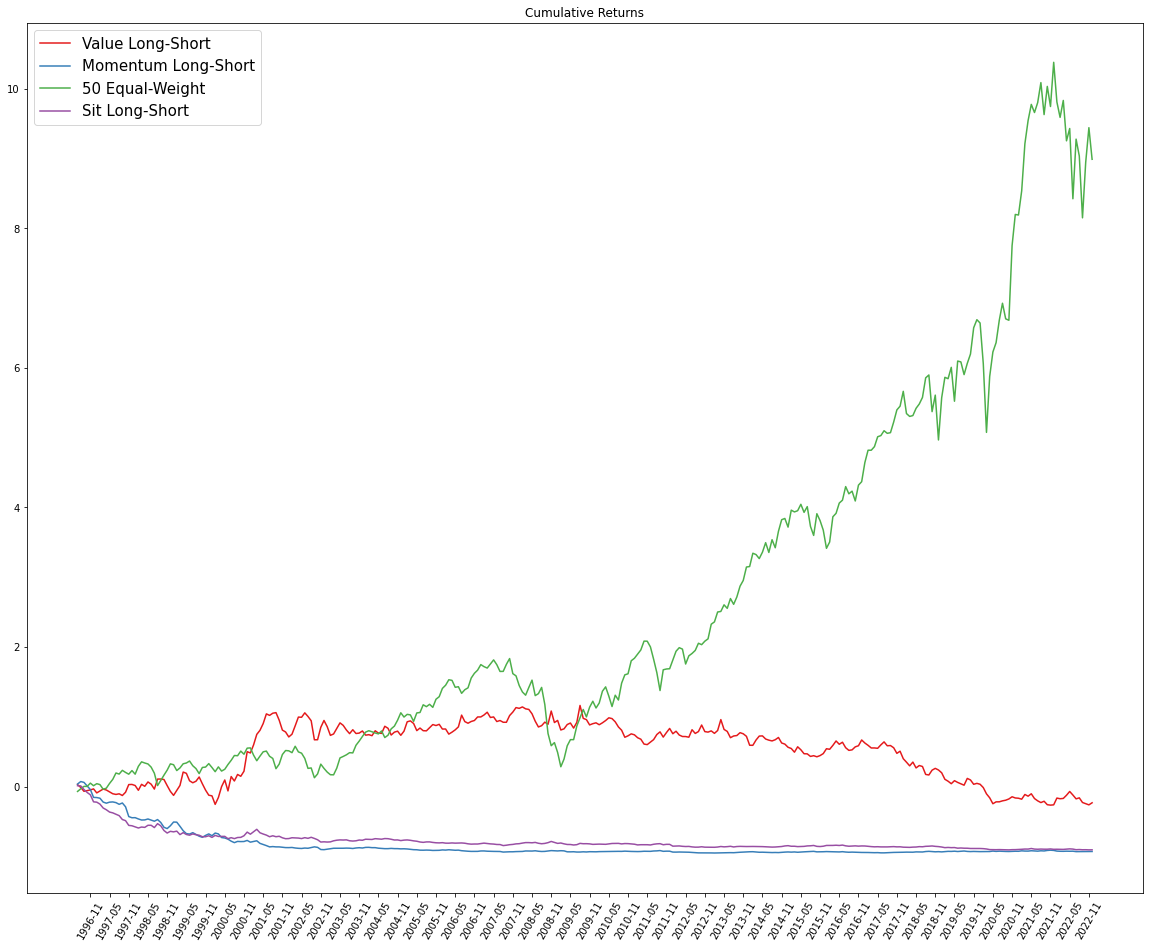

In [42]:
# plot long-short performance based on Sit compared to the previously viewed portfolios
series = [value_long_short, momentum_long_short, equal_weight, sit_long_short]
df4_1 = merge_mult_dfs_inner(series, on='Date')
plot_cumulative_returns(df4_1.reset_index(), 'Set1', labels=['Value Long-Short', 'Momentum Long-Short', '50 Equal-Weight', 'Sit Long-Short'])

# 5.
#### Discuss how the performance of the strategy at the previous point compares to a mixed strategy that simply invests 50% in the the value long-short portfolio and 50% in the momentum long- short portfolio.

In [43]:
df5 = merge_mult_dfs_inner([value_long_short, momentum_long_short], on='Date')

In [44]:
# construct the 50/50 strategy in value and momentum
fifty_val_mom = (df5.Value_LS * 0.5) + (df5.Momentum_LS * 0.5)
fifty_val_mom.name = 'fifty_ValMoM'

In [45]:
series = [sit_long_short, fifty_val_mom]
df5_1 = merge_mult_dfs_outer(series, left_index=True, right_index=True)
summary_stats(df5_1, riskfree_rate=0).round(decimals=3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown
Sit_LS,-0.085,0.157,-0.065,1.494,-0.542,-0.908
fifty_ValMoM,-0.043,0.106,0.178,2.654,-0.405,-0.702


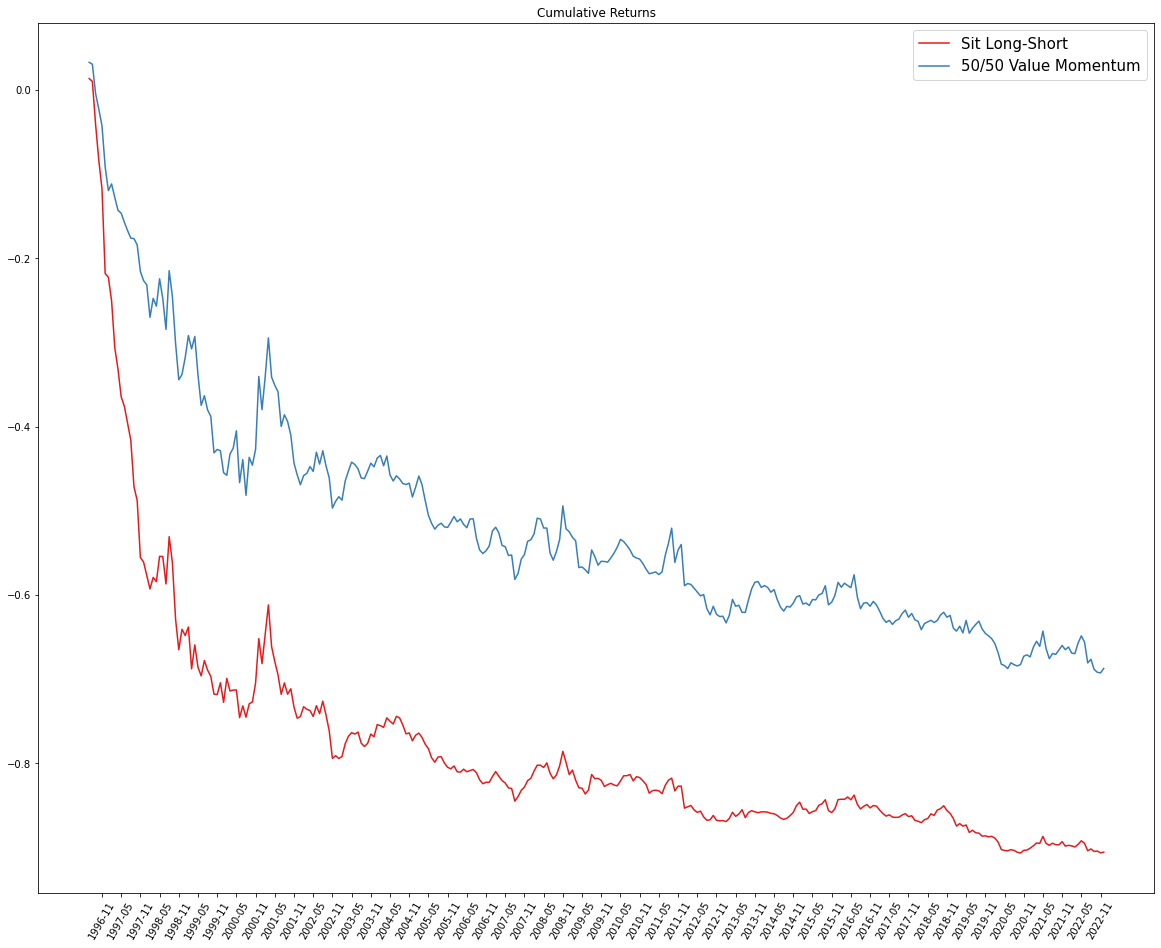

In [46]:
df5_2 = merge_mult_dfs_inner(series, on='Date')
plot_cumulative_returns(df5_2.reset_index(), 'Set1', labels=['Sit Long-Short', '50/50 Value Momentum'])

Based on the provided results, let's compare the performance of the Sit_LS portfolio with the mixed strategy that combines 50% in the Value long-short portfolio and 50% in the Momentum long-short portfolio:

- **Annualized Return:** The Sit_LS portfolio has an annualized return of -0.085, while the mixed strategy has an annualized return of -0.043. The mixed strategy outperforms the Sit_LS portfolio in terms of annualized return.

- **Annualized Volatility:** The Sit_LS portfolio has an annualized volatility of 0.157, while the mixed strategy has an annualized volatility of 0.106. The mixed strategy has lower volatility compared to the Sit_LS portfolio, indicating lower risk.

- **Skewness:** The Sit_LS portfolio has a skewness of -0.065, while the mixed strategy has a skewness of 0.178. Skewness measures the asymmetry of returns distribution. The mixed strategy has positive skewness, indicating a potential for higher positive returns compared to the Sit_LS portfolio.

- **Kurtosis:** The Sit_LS portfolio has a kurtosis of 1.494, while the mixed strategy has a kurtosis of 2.654. Kurtosis measures the fatness of tails in the returns distribution. The mixed strategy has higher kurtosis, indicating potentially more extreme returns, both positive and negative, compared to the Sit_LS portfolio.

- **Sharpe Ratio:** The Sit_LS portfolio has a Sharpe ratio of 1.494, while the mixed strategy has a Sharpe ratio of 2.654. The mixed strategy has a higher Sharpe ratio, indicating better risk-adjusted performance.

- **Max Drawdown:** The Sit_LS portfolio has a maximum drawdown of -0.908, while the mixed strategy has a maximum drawdown of -0.702. The mixed strategy experiences a smaller maximum drawdown, indicating lower loss during the worst period.

Overall, the mixed strategy that combines 50% in the Value long-short portfolio and 50% in the Momentum long-short portfolio outperforms the Sit_LS portfolio in terms of annualized return, volatility, Sharpe ratio, and maximum drawdown. However, the mixed strategy also exhibits higher positive skewness and higher kurtosis, suggesting potentially more extreme returns compared to the Sit_LS portfolio. Nevertheless it is important to notice that the Sit portfolio is being influenced by the negative signal of momentum being used, that when combined with the value signal, is producing even worse results. Assuming that we are indeed dealing with a case of mean-reversion on the first month, we are going long value stocks, and long stocks that will mean-revert down, which doesn't make any sense, since value looks for stocks that are undervalued. This can justify such a poor performance.

# 6.
#### Consider the long-short portfolios on Value, Momentum, the mixed charateristic S and the equally weighted portfolio. Run performance analysis of this strategies against FF5M model. Comment on the alphas, the factor exposures and the R2 of the factor regressions.

In [47]:
# import the fama-french data (got directly from fama-french website)
ff5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')
ff5.drop('RF', axis=1, inplace=True)
ff5['Date'] = pd.to_datetime(ff5.Date, format="%Y%m").dt.strftime('%Y-%m')
ff5.iloc[:,1:6] = ff5.iloc[:,1:6] / 100
ff5.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA
0,1963-07,-0.0039,-0.0041,-0.0097,0.0068,-0.0118
1,1963-08,0.0507,-0.0080,0.0180,0.0036,-0.0035
2,1963-09,-0.0157,-0.0052,0.0013,-0.0071,0.0029
3,1963-10,0.0253,-0.0139,-0.0010,0.0280,-0.0201
4,1963-11,-0.0085,-0.0088,0.0175,-0.0051,0.0224


In [48]:
# build dfs necessary to perform regression

ff5_value = pd.merge(value_long_short, ff5, on='Date', how='inner')
ff5_value.rename(columns={'Value_LS': 'Ret'}, inplace=True)

ff5_momentum = pd.merge(momentum_long_short, ff5, on='Date', how='inner')
ff5_momentum.rename(columns={'Momentum_LS': 'Ret'}, inplace=True)

ff5_ew = pd.merge(equal_weight, ff5, on='Date', how='inner')
ff5_ew.rename(columns={'EW_portf': 'Ret'}, inplace=True)

ff5_sit = pd.merge(sit_long_short, ff5, on='Date', how='inner')
ff5_sit.rename(columns={'Sit_LS': 'Ret'}, inplace=True)

In [49]:
# Function to do regression on each column individually.
import statsmodels.api as sm

def regress(df):

    endog = df['Ret']
    exog = sm.add_constant(df[df.drop(['Date', 'Ret'], axis=1).columns])
    reg = sm.OLS(endog, exog).fit()
    print(reg.summary())

In [50]:
regress(ff5_value)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     38.12
Date:                Fri, 12 May 2023   Prob (F-statistic):           1.47e-30
Time:                        19:47:27   Log-Likelihood:                 576.51
No. Observations:                 322   AIC:                            -1141.
Df Residuals:                     316   BIC:                            -1118.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.448      0.6

In [51]:
regress(ff5_momentum)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     5.969
Date:                Fri, 12 May 2023   Prob (F-statistic):           2.73e-05
Time:                        19:47:28   Log-Likelihood:                 492.48
No. Observations:                 318   AIC:                            -973.0
Df Residuals:                     312   BIC:                            -950.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0050      0.003     -1.631      0.1

In [52]:
# get the risk-free rate data
rf = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')
rf = rf[['Date', 'RF']]
rf['Date'] = pd.to_datetime(rf.Date, format="%Y%m").dt.strftime('%Y-%m')
rf.iloc[:,1] = rf.iloc[:,1] / 100

In [53]:
# adjust equal weighted portfolio to the risk-free data
rf_ew = merge_mult_dfs_inner([rf, ff5_ew], on='Date')
rf_ew['Ret'] = rf_ew['Ret'] - rf_ew['RF']
ff5_ew = rf_ew.drop(columns=['RF'])

In [54]:
regress(ff5_ew.dropna())    # drop na because no value for ew in first row

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     498.3
Date:                Fri, 12 May 2023   Prob (F-statistic):          1.94e-193
Time:                        19:47:28   Log-Likelihood:                 1280.5
No. Observations:                 515   AIC:                            -2549.
Df Residuals:                     509   BIC:                            -2524.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -1.150      0.2

In [55]:
regress(ff5_sit)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     11.45
Date:                Fri, 12 May 2023   Prob (F-statistic):           3.66e-10
Time:                        19:47:29   Log-Likelihood:                 559.93
No. Observations:                 318   AIC:                            -1108.
Df Residuals:                     312   BIC:                            -1085.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0060      0.002     -2.421      0.0

Based on the regression results provided, we can analyze the alphas, factor exposures, and R-squared values for each strategy's factor regressions. Here are the comments for each strategy:

**Fama-French 5 Value:**

- Alpha: The intercept term (const) is -0.0011. Since it is not significantly different from zero (p-value = 0.655), it suggests that the strategy does not exhibit a significant abnormal return after accounting for the Fama-French factors.
- Factor Exposures: The coefficients for the factors are as follows: Mkt-RF (-0.0791), SMB (-0.3243), HML (0.5972), RMW (-0.0508), and CMA (0.5003). These coefficients indicate the strategy's exposure to each factor. For example, a positive HML coefficient suggests that the strategy has a positive exposure to the value factor, which makes sense, since it is what we are trying to replicate. Also we can observe that the strategy is not statistically different from market-neutral (p-value > 0.05 for Mkt-RF factor).
- R-squared: The R-squared value of 0.376 indicates that the Fama-French factors can only explain 37.6% of the variation in the strategy's returns.

**Fama-French 5 Momentum:**

- Alpha: The intercept term (const) is -0.0050. It is not significantly different from zero (p-value = 0.104), implying no significant abnormal return after considering the Fama-French factors.
- Factor Exposures: The coefficients for the factors are as follows: Mkt-RF (-0.2656), SMB (0.2750), HML (-0.2153), RMW (0.1921), and CMA (-0.2828). Notably, the positive coefficient for SML suggests a strong exposure to smaller equities. Also, an important indicator of why the performance for our momentum factor is so poor, is the negative exposure to the market (markets have an upwards tendency that is verified in the equal-weighted portfolio).
- R-squared: The R-squared value of 0.087 indicates that the Fama-French factors can explain only 8.7% of the variation in the strategy's returns, suggesting a very weak relationship.

**Fama-French 5 Equal Weights:**

- Alpha: The intercept term (const) is -0.0011, and it is not significantly different from zero. This suggests that the 50 stocks assigned to the group are not outperformingn, nor underperforming the market, which is in line with what would be expected.
- Factor Exposures: The coefficients for the factors are as follows: Mkt-RF (0.9878), SMB (0.1366), HML (0.1763), RMW (0.0717), and CMA (0.0302). The positive coefficients indicate the strategy's positive exposure to the market, size and value factors.
- R-squared: The R-squared value of 0.83 indicates that the Fama-French factors can explain a substantial portion (83%) of the variation in the strategy's returns.

**Fama-French 5 Sit:**

- Alpha: The intercept term (const) is -0.0060, and it is significantly different from zero (p-value = 0.016). This suggests a negative abnormal return for the strategy.
- Factor Exposures: The coefficients for the factors are as follows: Mkt-RF (-0.2694), SMB (0.1685), HML (0.1658), RMW (0.0953), and CMA (0.1860). The negative coefficient for Mkt-RF indicates a negative exposure to the market factor, while the positive coefficients for SMB, HML, and CMA suggest positive exposure to the size, value, and profitability factors, respectively. This leads us to assume that the negative performance of the Sit signal, is driven by a negative exposure to the market, that can be derived from the negative exposure of the momentum factor to the market (not aided by the weak exposure of the value strategy).
- R-squared: The R-squared value of 0.087 indicates that the Fama-French factors cannot explain most of the variation in the strategy's returns.

# 7.
#### Is the performance analysis (α) driven mostly by one of the two legs (long ot short)? Discuss the implications for trading on long-only versus long-short tercile portfolios.

#### **Value**

In [56]:
value_long = merge_mult_dfs_inner([val_rets, ff5, rf], on='Date').drop(columns=['Value_med', 'Value_low']).rename(columns={'Value_high': 'Ret'})
value_long['Ret'] = value_long['Ret'] - value_long['RF']
value_long = value_long.drop(columns=['RF'])

value_short = merge_mult_dfs_inner([val_rets, ff5, rf], on='Date').drop(columns=['Value_med', 'Value_high']).rename(columns={'Value_low': 'Ret'})
value_short['Ret'] = value_short['Ret'] - value_short['RF']
value_short = value_short.drop(columns=['RF'])

In [57]:
regress(value_long)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     148.3
Date:                Fri, 12 May 2023   Prob (F-statistic):           1.16e-80
Time:                        19:47:29   Log-Likelihood:                 691.04
No. Observations:                 322   AIC:                            -1370.
Df Residuals:                     316   BIC:                            -1347.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.002     -1.918      0.0

In [58]:
regress(value_short)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     187.6
Date:                Fri, 12 May 2023   Prob (F-statistic):           2.56e-92
Time:                        19:47:29   Log-Likelihood:                 684.98
No. Observations:                 322   AIC:                            -1358.
Df Residuals:                     316   BIC:                            -1335.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.255      0.2

#### **Momentum**

In [59]:
momentum_long = merge_mult_dfs_inner([mom_rets, ff5, rf], on='Date').drop(columns=['MoM_med', 'MoM_low']).rename(columns={'MoM_high': 'Ret'})
momentum_long['Ret'] = momentum_long['Ret'] - momentum_long['RF']
momentum_long = momentum_long.drop(columns=['RF'])

momentum_short = merge_mult_dfs_inner([mom_rets, ff5, rf], on='Date').drop(columns=['MoM_med', 'MoM_high']).rename(columns={'MoM_low': 'Ret'})
momentum_short['Ret'] = momentum_short['Ret'] - momentum_short['RF']
momentum_short = momentum_short.drop(columns=['RF'])

In [60]:
regress(momentum_long)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     109.5
Date:                Fri, 12 May 2023   Prob (F-statistic):           1.64e-66
Time:                        19:47:30   Log-Likelihood:                 624.76
No. Observations:                 318   AIC:                            -1238.
Df Residuals:                     312   BIC:                            -1215.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.002     -2.168      0.0

In [61]:
regress(momentum_short)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     166.0
Date:                Fri, 12 May 2023   Prob (F-statistic):           1.15e-85
Time:                        19:47:30   Log-Likelihood:                 627.04
No. Observations:                 318   AIC:                            -1242.
Df Residuals:                     312   BIC:                            -1220.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.307      0.7

#### **Sit**

In [62]:
sit_long = merge_mult_dfs_inner([sit_rets, ff5, rf], on='Date').drop(columns=['Sit_med', 'Sit_low']).rename(columns={'Sit_high': 'Ret'})
sit_long['Ret'] = sit_long['Ret'] - sit_long['RF']
sit_long = sit_long.drop(columns=['RF'])

sit_short = merge_mult_dfs_inner([sit_rets, ff5, rf], on='Date').drop(columns=['Sit_med', 'Sit_high']).rename(columns={'Sit_low': 'Ret'})
sit_short['Ret'] = sit_short['Ret'] - sit_short['RF']
sit_short = sit_short.drop(columns=['RF'])

In [63]:
regress(sit_long)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     120.5
Date:                Fri, 12 May 2023   Prob (F-statistic):           1.10e-70
Time:                        19:47:31   Log-Likelihood:                 663.78
No. Observations:                 318   AIC:                            -1316.
Df Residuals:                     312   BIC:                            -1293.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -2.178      0.0

In [64]:
regress(sit_short)

                            OLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     214.8
Date:                Fri, 12 May 2023   Prob (F-statistic):           9.74e-99
Time:                        19:47:31   Log-Likelihood:                 678.22
No. Observations:                 318   AIC:                            -1344.
Df Residuals:                     312   BIC:                            -1322.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      1.232      0.2

**Findings:**

The only statistically significant alphas found, was for the short portfolio on the momentum signal, and the long portfolio on the Sit signal. As these alphas are statiticaly significant, we can conclude that the performance analylis is driven primarly by the short portfolios performance in the momentum factor. As for the Sit negative performance, it is being driven by the combination of high momentum and high value which is quite unusual, and for which we cannot find a proper justification. These findings explain the negative alpha found when regressing the long shorts portfolio against our FamaFrench5 model.

As the for the value and momentum models we find that there are not significant alphas which is in line with what was found for the long short portfolios.


**Implications for trading on long-only versus long-short tercile portfolios:**

In the case of long-only tercile portfolios, investing in the top-performing one-third of assets can provide an opportunity for higher returns, but also potentially exposes the investor to higher levels of risk. This is because the top-performing assets may be more volatile or subject to larger market fluctuations than the rest of the market. As such, long-only tercile portfolios may be suitable for investors who are willing to take on higher levels of risk in exchange for potentially higher returns.

On the other hand, long-short tercile portfolios may offer more opportunities for risk management and alpha generation. By taking long and short positions in the top- and bottom-performing one-third of assets, investors can potentially capture returns from both rising and falling markets while also reducing overall portfolio risk. This is because the short positions can act as a hedge against losses in the long positions. However, constructing and managing a long-short tercile portfolio can be more complex and require more active management than a long-only tercile portfolio.

Another implication of long-short portfolios is that they provide more opportunities for alpha generation as by taking both long and short positions, investors can attempt to capture alpha in both rising and falling markets, whereas long-only portfolios are limited to capturing alpha only in rising markets.

Long-short portfolios also offer greater flexibility in terms of portfolio construction and management. For example, investors can use a variety of strategies, such as relative value or market neutral, to construct their portfolios. Additionally, they can adjust the size of their positions based on market conditions, which can help to reduce risk and enhance returns.

# 8. 
#### Discuss theoretically how to modify the construction of the long-short Value portfolio in order to make it market neutral (i.e. uncorrelated with returns on the market portfolio) over a rolling widow of 3 years.

B=0:

A long-short value portfolio's beta must be zero when compared to the market, meaning it is unaffected by broad market fluctuations, in order for the portfolio to be considered market-neutral over a rolling timeframe of three years. A portfolio's beta reflects how sensitive it is to market movements; a beta of 0 means that market changes have no impact on the portfolio's results.

In the case of a long-short value portfolio, the long positions in undervalued stocks are expected to generate positive returns over time, while the short positions in overvalued stocks are expected to generate negative returns. The returns on the long and short positions, however, will be impacted by movements in the market if the portfolio's beta is positive, which could reduce the effectiveness of the long-short approach. For instance, in a bear market, the value of the long positions may decrease while the value of the short positions may rise, which can offset the gains from the long positions.

By ensuring that the portfolio's beta is zero with respect to the market, The portfolio can be constructed to produce returns only from the long-short value approach, independent of market fluctuations. This can increase the efficiency of the long-short value strategy and lower the total risk of the portfolio.

How to achieve this:

- Introduce short positions in index futures or ETFs: by shorting these instruments, the portfolio's beta can be brought down to zero (It requires careful consideration of the size of the short positions relative to the long positions in order to guarantee that the portfolio remains long-short value in nature);
- Use statistical arbitrage techniques: identifying pairs of stocks that have similar risk factors but are mispriced relative to each other (by taking long and short positions in these pairs, the portfolio's beta can be brought down to zero);
- Implement a factor-neutral strategy aims to neutralize the portfolio's exposure to various risk factors, including market beta. This is achieved by ensuring that the portfolio's exposure to each factor is zero (in this case, this means that the portfolio's exposure to both the value factor and the market factor needs to be zero.

Overall, the key to constructing a market-neutral long-short value portfolio is to carefully balance the long and short positions to ensure that the portfolio's exposure to market risk is neutralized. Since we assume there is no perfect correlation between securities, we can also state there is a factor neutrality in long-short portfolios because securities movements’ offset each other. As we can observe in the following formula: HML: Long (t) – Short (t), long(t) is expected, on average, to overperformed the market, while short(t), is expected, on average, to underperform the market resulting in a market neutrality. 